<a href="https://colab.research.google.com/github/ViniciusHideki/MD_Mineracao/blob/main/ReinforcementLearning_Trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O código foi feito para o trabalho da disciplina de Mineração da UFSCar.

Colaboradores:
* Luben 
* Luiz
* Vinicius



# Q-Learning - Exemplo do Lago Congelado

In [ ]:
!pip install numpy
!pip install gym

In [ ]:
import pandas as pd
import numpy as np
import gym
import random
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

## Função que cria a Tabela-Q

* Epochs: número de vezes que a criança treino no algoritmo;

* alpha: taxa de aprendizado;

* max_passos: é o número máximo de passos que a criança pode dar em um episódio (pode ocorrer que ela fique andando infinitamente no bloco);

* epison, min_epsilon e decay_rate: hiperparâmetros relativos aos a busca por greedy, mas não está sendo usado;

* recompensa_buraco: pontuação ao cair no buraco;

* recompensa_gelo: pontuação ao andar no gelo;

* recompensa_objetivo: pontuação ao atingir a mochila;

* semente: para obter resultados sem ser aleatórios, pode-se mudar para obter outros resultados;

* escorrega: True(a criança pode escoregar no gelo) ou False(a criança andar com firmeza)

In [ ]:

def cria_tabela_Q(epochs,alpha,max_passos,gamma,epsilon,min_epsilon,decay_rate,
                  recompensa_buraco,recompensa_gelo,recompensa_objetivo,semente,
                  escorrega):
  
  env = gym.make("FrozenLake-v0",is_slippery=escorrega)
  random.seed(semente)
  np.random.seed(semente)
  env.seed(semente)
  env.action_space.seed(semente)

  max_epsilon=epsilon
  TB_Q = np.zeros([env.observation_space.n,env.action_space.n])

  passos = []
  recompensas = []
  
  for ep in range(epochs):
    s = env.reset() # Inicializando o lago congelado
    fim = False     # Armazena se o garoto caiu no buraco ou encontrou o frisbee
    j = 0           # Número de passos dados no episódio
    # Inicializando o algoritmo
    soma_recompensa = 0
    while j < max_passos:  # Número máximo de passos por episódio 
        j+=1

        acao = np.argmax(TB_Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(j+1)))

        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        #if np.random.uniform(0, 1) > epsilon:
        #    acao = np.argmax(TB_Q[s,:])
            #print("action", acao)

        # Else doing a random choice --> exploration
        #else:
        #    acao = env.action_space.sample()
            #print("action random", acao)

        # Tomando a ação escolhida
        st, recompensa, fim, _ = env.step(acao)
        
        # Novas configurações
        
        if recompensa == 0 and fim == True:
            recompensa = recompensa_buraco
        elif recompensa == 0 and fim == False:
            recompensa = recompensa_gelo
        elif recompensa == 1 and fim == True:
            recompensa = recompensa_objetivo

        # Atualizando a tabela Q
        TB_Q[s,acao] = TB_Q[s,acao] + alpha*(recompensa + gamma*np.max(TB_Q[st,:]) - TB_Q[s,acao])
        # Atualizando o estado
        s = st   
        
        # Caso usar recompensas personalizadas
        soma_recompensa += recompensa
        
        # Verificando se o garoto caiu no buraco ou encontrou o frisbee 
        if fim == True:
            break

    #epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*ep)       
    passos.append(j)
    recompensas.append(soma_recompensa)

  return(TB_Q)

## Função que cria a Tabela-Q

* TB_Q: Tabela Q 
* verbo: 
* Se 1, printa as descritivas;

* Se 0, nao printa as descritivas;

* Se 2, printa as descritivas e mostra o que a criança;


In [ ]:
def testa_tabela_Q(epochs,TB_Q,semente,recompensa_buraco,recompensa_gelo,recompensa_objetivo,escorrega,verbo=1):

  env = gym.make("FrozenLake-v0",is_slippery=escorrega)
  random.seed(semente)
  np.random.seed(semente)
  env.seed(semente)
  env.action_space.seed(semente)

  passos_totais, penalidades_totais, mochilas_totais = 0, 0, 0
  serie_recompensa = np.zeros(epochs)

  for ep in range(epochs):
    s = env.reset()
    passos, penalidade, sucesso = 0, 0, 0
    sum = 0
    fim = False
    while not fim:
      
        acao = np.argmax(TB_Q[s])
        s, recompensa, fim, _ = env.step(acao)
        if fim == True and recompensa == 0:
          sum += recompensa_buraco
          penalidade += 1
        elif recompensa == 0 and fim == False:
          sum += recompensa_gelo
        elif recompensa == 1 and fim == True:
          sum += recompensa_objetivo
          sucesso += 1


        if(verbo==2):
          clear_output(wait=True)
          env.render()
          sleep(.5) 

        passos += 1


    passos_totais += passos   
    mochilas_totais += sucesso
    penalidades_totais += penalidade
    serie_recompensa[ep] = sum

  if(verbo==1):
    print(f"Resutados depois de {epochs} episodios:")
    print(f"Média de Passos por episódio: {passos_totais / epochs}")
    print(f"Média de Mortes (H) por episódio: {penalidades_totais / epochs}")
    print(f"Média de Mochilas (G) por episódio: {mochilas_totais / epochs}")
    print(f"Média da recompensa total: {np.mean(serie_recompensa)}")

  return( [ [(passos_totais/epochs), 
             (penalidades_totais/epochs),
             (mochilas_totais/epochs),
             np.mean(serie_recompensa)] ,
           serie_recompensa, np.arange(1, epochs + 1)])


## Lago Congelado 4x4 - Situação 0


In [ ]:
### Obtendo a Tabela q
%%time

semente_0 = 60000

TB_Q = cria_tabela_Q(epochs=60000,alpha=0.5,max_passos=50,gamma=0.9,
                     epsilon=1,min_epsilon=0.01,
                     decay_rate=0.005,recompensa_buraco=0,recompensa_gelo=0,
                     recompensa_objetivo=1,semente=semente_0,
                     escorrega=True)

print(TB_Q)

[[0.09455922 0.10481131 0.10618507 0.09203401]
 [0.03001858 0.07634962 0.09187991 0.09678124]
 [0.12029713 0.0851974  0.05318857 0.07670973]
 [0.03368936 0.01230226 0.01420976 0.05142912]
 [0.10535692 0.06515527 0.07744618 0.08370512]
 [0.         0.         0.         0.        ]
 [0.30624079 0.00376771 0.01188074 0.00336569]
 [0.         0.         0.         0.        ]
 [0.02992982 0.12592471 0.08370058 0.16749086]
 [0.08649134 0.23231974 0.17871411 0.05132513]
 [0.36887486 0.03879298 0.09278724 0.03751159]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.0687312  0.0505578  0.4114179  0.05139369]
 [0.18724414 0.89373182 0.17817577 0.27075376]
 [0.         0.         0.         0.        ]]
CPU times: user 18.5 s, sys: 1.04 s, total: 19.5 s
Wall time: 18.4 s


In [ ]:
print(pd.DataFrame(TB_Q).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &         0 &         1 &         2 &         3 \\
\midrule
0  &  0.094559 &  0.104811 &  0.106185 &  0.092034 \\
1  &  0.030019 &  0.076350 &  0.091880 &  0.096781 \\
2  &  0.120297 &  0.085197 &  0.053189 &  0.076710 \\
3  &  0.033689 &  0.012302 &  0.014210 &  0.051429 \\
4  &  0.105357 &  0.065155 &  0.077446 &  0.083705 \\
5  &  0.000000 &  0.000000 &  0.000000 &  0.000000 \\
6  &  0.306241 &  0.003768 &  0.011881 &  0.003366 \\
7  &  0.000000 &  0.000000 &  0.000000 &  0.000000 \\
8  &  0.029930 &  0.125925 &  0.083701 &  0.167491 \\
9  &  0.086491 &  0.232320 &  0.178714 &  0.051325 \\
10 &  0.368875 &  0.038793 &  0.092787 &  0.037512 \\
11 &  0.000000 &  0.000000 &  0.000000 &  0.000000 \\
12 &  0.000000 &  0.000000 &  0.000000 &  0.000000 \\
13 &  0.068731 &  0.050558 &  0.411418 &  0.051394 \\
14 &  0.187244 &  0.893732 &  0.178176 &  0.270754 \\
15 &  0.000000 &  0.000000 &  0.000000 &  0.000000 \\
\bottomrule
\end{tabular}



In [ ]:
### Testando sua eficacia
resultado_TB_Q = testa_tabela_Q(epochs=1000,TB_Q=TB_Q,semente=semente_0*3,
                                recompensa_buraco=0,recompensa_gelo=0,
                                recompensa_objetivo=1,verbo=1,escorrega=True)

Resutados depois de 1000 episodios:
Média de Passos por episódio: 30.096
Média de Mortes (H) por episódio: 0.485
Média de Mochilas (G) por episódio: 0.515
Média da recompensa total: 0.515


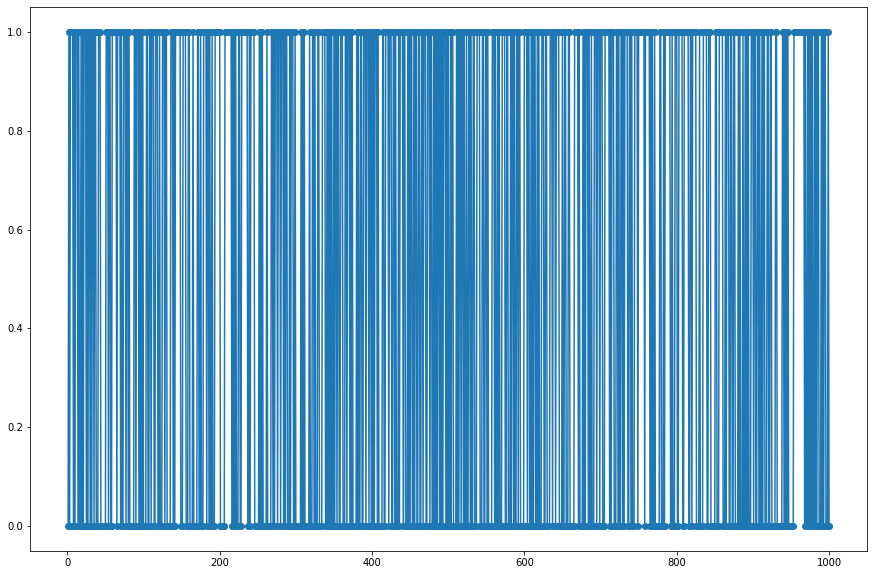

In [ ]:
#resultado_TB_Q[1]
plt.plot(  resultado_TB_Q[2], resultado_TB_Q[1] ,marker="o")
plt.gcf().set_size_inches(15, 10)
plt.show()

## Lago Congelado 4x4 - Situação 1


#### Definindo os hiperparâmetros 

* Recompensa de 100 se chegar na mochila.
* Recompensa de -10 se cair no buraco.
* Recompensa de -1 se andar no gelo.

In [ ]:
### Obtendo a Tabela q
%%time

semente_1 = 8

TB_Q1 = cria_tabela_Q(epochs=60000,alpha=0.5,max_passos=50,gamma=0.9,
                     epsilon=1,min_epsilon=0.01,
                     decay_rate=0.005,recompensa_buraco=-10,recompensa_gelo=-1,
                     recompensa_objetivo=100,semente=semente_1,
                      escorrega=True)
 
print(TB_Q1)

[[-0.55194846 -9.05413398 -8.90129924 -8.82919224]
 [-9.79229643 -9.56108793 -9.89320072 -6.30481219]
 [-9.75835564 -2.35748336 -9.74893483 -9.71222789]
 [-9.83537475 -9.93960052 -9.9200355  -8.50297724]
 [ 3.07726787 -9.84379946 -9.89554152 -9.82308312]
 [ 0.          0.          0.          0.        ]
 [-3.2496288  -9.90934139 -9.92311168 -9.92343449]
 [ 0.          0.          0.          0.        ]
 [-9.18634777 -8.95523282 -9.01102405 14.45397052]
 [-8.38402346 30.26806153 -8.8186708  -8.50571698]
 [21.11654417 -9.73603571 -9.73367959 -9.53169671]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-5.         -7.13933324 52.81898682 -6.91553147]
 [ 0.         94.42715633 -0.5         0.        ]
 [ 0.          0.          0.          0.        ]]
CPU times: user 1min 3s, sys: 1.23 s, total: 1min 5s
Wall time: 1min 3s


In [ ]:
print(pd.DataFrame(TB_Q1).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &          0 &          1 &          2 &          3 \\
\midrule
0  &  -0.551948 &  -9.054134 &  -8.901299 &  -8.829192 \\
1  &  -9.792296 &  -9.561088 &  -9.893201 &  -6.304812 \\
2  &  -9.758356 &  -2.357483 &  -9.748935 &  -9.712228 \\
3  &  -9.835375 &  -9.939601 &  -9.920036 &  -8.502977 \\
4  &   3.077268 &  -9.843799 &  -9.895542 &  -9.823083 \\
5  &   0.000000 &   0.000000 &   0.000000 &   0.000000 \\
6  &  -3.249629 &  -9.909341 &  -9.923112 &  -9.923434 \\
7  &   0.000000 &   0.000000 &   0.000000 &   0.000000 \\
8  &  -9.186348 &  -8.955233 &  -9.011024 &  14.453971 \\
9  &  -8.384023 &  30.268062 &  -8.818671 &  -8.505717 \\
10 &  21.116544 &  -9.736036 &  -9.733680 &  -9.531697 \\
11 &   0.000000 &   0.000000 &   0.000000 &   0.000000 \\
12 &   0.000000 &   0.000000 &   0.000000 &   0.000000 \\
13 &  -5.000000 &  -7.139333 &  52.818987 &  -6.915531 \\
14 &   0.000000 &  94.427156 &  -0.500000 &   0.000000 \\
15 &   0.000000 &   0.000000 & 

In [ ]:
### Testando sua eficacia
resultado_TB_Q1 = testa_tabela_Q(epochs=1000,TB_Q=TB_Q1,semente=semente_1*3,
                                recompensa_buraco=-10,recompensa_gelo=-1,
                                recompensa_objetivo=100,verbo=2,
                                 escorrega=True)

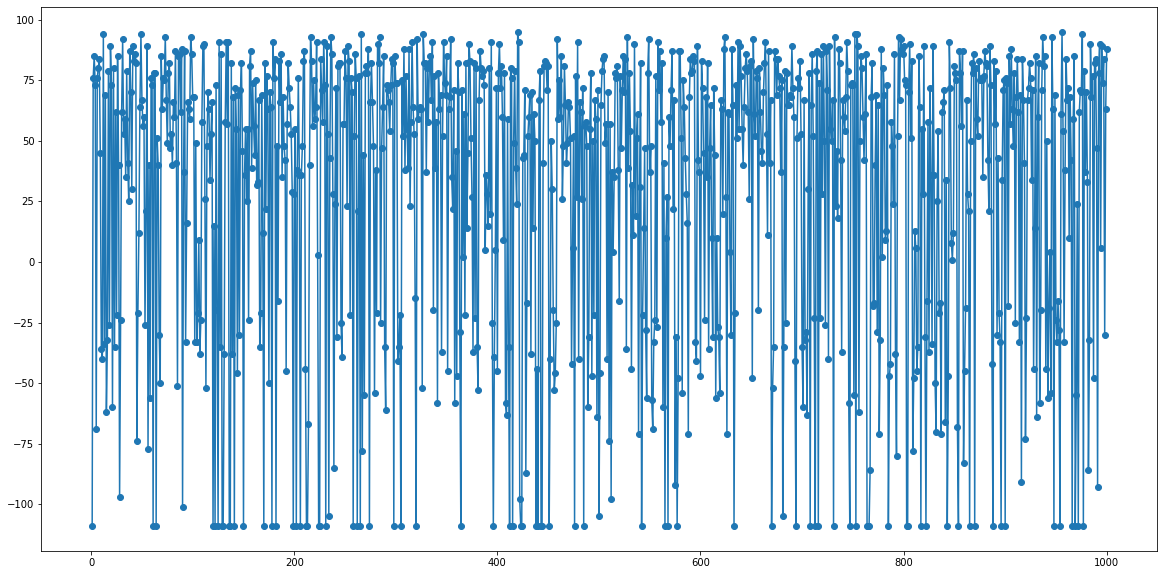

In [ ]:
plt.plot( resultado_TB_Q1[2], resultado_TB_Q1[1],marker="o")
plt.gcf().set_size_inches(20, 10)
plt.show()

## Lago Congelado 4x4 - Situação 2


In [ ]:
### Obtendo a Tabela q
%%time

semente_2 = 77

TB_Q2 = cria_tabela_Q(epochs=60000,alpha=0.5,max_passos=50,gamma=0.9,
                     epsilon=1,min_epsilon=0.01,
                     decay_rate=0.005,recompensa_buraco=-100,recompensa_gelo=-10,
                     recompensa_objetivo=1000,semente=semente_2,escorrega=True)
 
print(TB_Q2)

[[-44.35155993 -96.03334272 -95.38123089 -95.37736932]
 [-98.96883073 -99.23103916 -99.18889945 -40.10190359]
 [-98.67079579 -42.033525   -98.8357563  -98.59403049]
 [-99.11921309 -99.27121618 -99.32934273 -66.28358513]
 [ 45.85391382 -95.15320882 -96.96847793 -95.39915529]
 [  0.           0.           0.           0.        ]
 [-99.89153133 -99.95307166  54.76827439 -99.96164016]
 [  0.           0.           0.           0.        ]
 [-90.65004522 -93.84974202 -92.92436219 165.64033295]
 [-86.40728235 282.43100565 -85.91518128 -84.44097639]
 [142.99170636 -95.72320514 -96.76753833 -97.82369526]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [-62.33466505 -57.13125    431.69016913 -73.77255663]
 [-14.2625     788.24381089 -16.26435529 -21.33894978]
 [  0.           0.           0.           0.        ]]
CPU times: user 1min 5s, sys: 2.63 s, total: 1min 8s
Wall time: 1min 5s


In [ ]:
print(pd.DataFrame(TB_Q2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &           0 &           1 &           2 &           3 \\
\midrule
0  &  -44.351560 &  -96.033343 &  -95.381231 &  -95.377369 \\
1  &  -98.968831 &  -99.231039 &  -99.188899 &  -40.101904 \\
2  &  -98.670796 &  -42.033525 &  -98.835756 &  -98.594030 \\
3  &  -99.119213 &  -99.271216 &  -99.329343 &  -66.283585 \\
4  &   45.853914 &  -95.153209 &  -96.968478 &  -95.399155 \\
5  &    0.000000 &    0.000000 &    0.000000 &    0.000000 \\
6  &  -99.891531 &  -99.953072 &   54.768274 &  -99.961640 \\
7  &    0.000000 &    0.000000 &    0.000000 &    0.000000 \\
8  &  -90.650045 &  -93.849742 &  -92.924362 &  165.640333 \\
9  &  -86.407282 &  282.431006 &  -85.915181 &  -84.440976 \\
10 &  142.991706 &  -95.723205 &  -96.767538 &  -97.823695 \\
11 &    0.000000 &    0.000000 &    0.000000 &    0.000000 \\
12 &    0.000000 &    0.000000 &    0.000000 &    0.000000 \\
13 &  -62.334665 &  -57.131250 &  431.690169 &  -73.772557 \\
14 &  -14.262500 &  788.24381

In [ ]:
### Testando sua eficacia
resultado_TB_Q2 = testa_tabela_Q(epochs=1000,TB_Q=TB_Q2,semente=semente_2*3,
                                recompensa_buraco=-100,recompensa_gelo=-10,
                                recompensa_objetivo=1000,verbo=1,escorrega=True)

Resutados depois de 1000 episodios:
Média de Passos por episódio: 41.929
Média de Mortes (H) por episódio: 0.265
Média de Mochilas (G) por episódio: 0.735
Média da recompensa total: 299.21


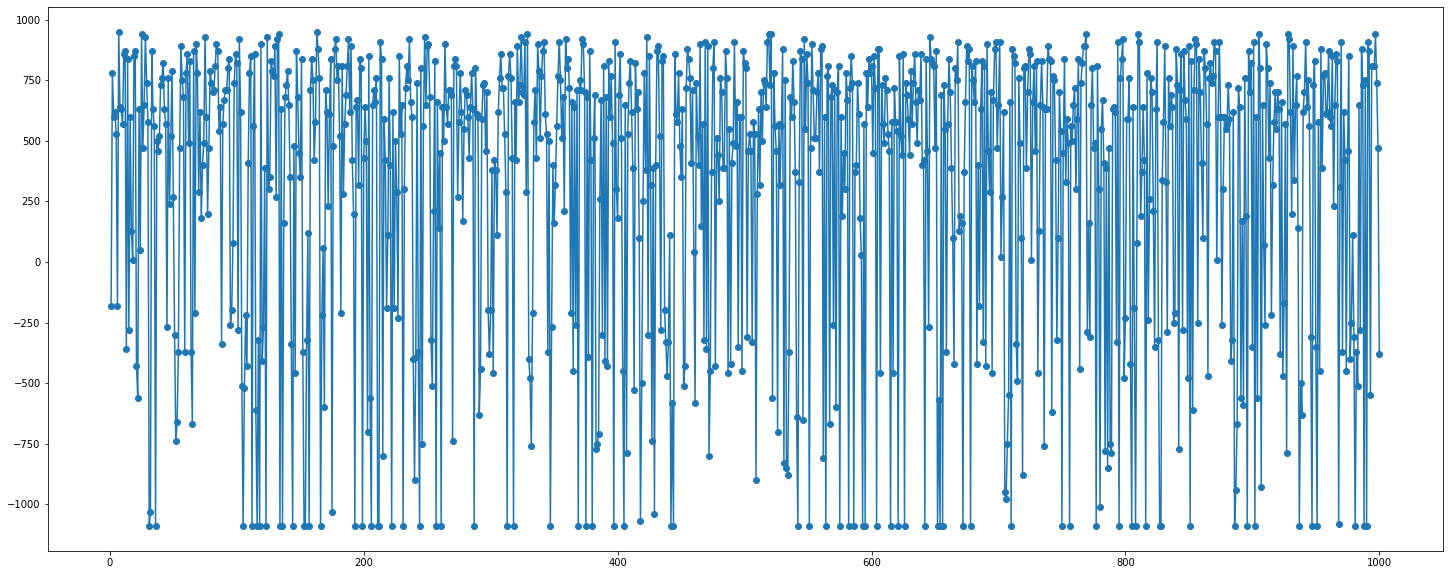

In [ ]:
plt.plot( resultado_TB_Q2[2], resultado_TB_Q2[1] ,marker="o")
plt.gcf().set_size_inches(25, 10)
plt.show()

# Sem Escorregar

# Situação 0

In [ ]:
### Obtendo a Tabela q
%%time

semente_0_sem = 5000

TB_Q_sem  = cria_tabela_Q(epochs=60000,alpha=0.5,max_passos=50,gamma=0.9,
                     epsilon=1,min_epsilon=0.01,
                     decay_rate=0.005,recompensa_buraco=0,recompensa_gelo=0,
                     recompensa_objetivo=1,semente=semente_0_sem,
                     escorrega=False)
 
print(TB_Q_sem)

[[0.531441 0.59049  0.59049  0.531441]
 [0.531441 0.       0.6561   0.59049 ]
 [0.59049  0.729    0.59049  0.6561  ]
 [0.6561   0.       0.59049  0.59049 ]
 [0.59049  0.6561   0.       0.531441]
 [0.       0.       0.       0.      ]
 [0.       0.81     0.       0.6561  ]
 [0.       0.       0.       0.      ]
 [0.6561   0.       0.729    0.59049 ]
 [0.6561   0.6561   0.81     0.      ]
 [0.       0.9      0.       0.729   ]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.729   ]
 [0.       0.       1.       0.81    ]
 [0.       0.       0.       0.      ]]
CPU times: user 21.9 s, sys: 245 ms, total: 22.1 s
Wall time: 21.8 s


In [ ]:
print( pd.DataFrame(TB_Q_sem).to_latex() )

\begin{tabular}{lrrrr}
\toprule
{} &         0 &        1 &        2 &         3 \\
\midrule
0  &  0.531441 &  0.59049 &  0.59049 &  0.531441 \\
1  &  0.531441 &  0.00000 &  0.65610 &  0.590490 \\
2  &  0.590490 &  0.72900 &  0.59049 &  0.656100 \\
3  &  0.656100 &  0.00000 &  0.59049 &  0.590490 \\
4  &  0.590490 &  0.65610 &  0.00000 &  0.531441 \\
5  &  0.000000 &  0.00000 &  0.00000 &  0.000000 \\
6  &  0.000000 &  0.81000 &  0.00000 &  0.656100 \\
7  &  0.000000 &  0.00000 &  0.00000 &  0.000000 \\
8  &  0.656100 &  0.00000 &  0.72900 &  0.590490 \\
9  &  0.656100 &  0.65610 &  0.81000 &  0.000000 \\
10 &  0.000000 &  0.90000 &  0.00000 &  0.729000 \\
11 &  0.000000 &  0.00000 &  0.00000 &  0.000000 \\
12 &  0.000000 &  0.00000 &  0.00000 &  0.000000 \\
13 &  0.000000 &  0.00000 &  0.00000 &  0.729000 \\
14 &  0.000000 &  0.00000 &  1.00000 &  0.810000 \\
15 &  0.000000 &  0.00000 &  0.00000 &  0.000000 \\
\bottomrule
\end{tabular}



In [ ]:
### Testando sua eficacia
resultado_TB_Q_sem = testa_tabela_Q(epochs=1000,TB_Q=TB_Q_sem,semente=semente_0_sem*3,
               recompensa_buraco=0,recompensa_gelo=0,
               recompensa_objetivo=1,verbo=1,escorrega=False)

Resutados depois de 1000 episodios:
Média de Passos por episódio: 6.0
Média de Mortes (H) por episódio: 0.0
Média de Mochilas (G) por episódio: 1.0
Média da recompensa total: 1.0


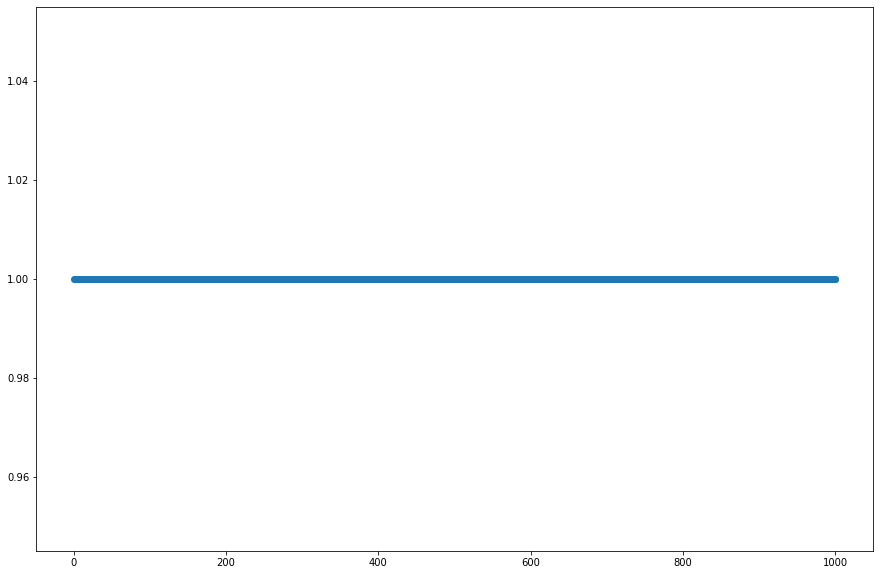

In [ ]:
plt.plot(  resultado_TB_Q_sem[2], resultado_TB_Q_sem[1] ,marker="o")
plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
dados_dos_testes = pd.DataFrame( data= [ resultado_TB_Q[0],resultado_TB_Q1[0],resultado_TB_Q2[0],resultado_TB_Q_sem[0] ] )
print(dados_dos_testes.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &       0 &      1 &      2 &        3 \\
\midrule
0 &  30.096 &  0.485 &  0.515 &    0.515 \\
1 &  41.570 &  0.287 &  0.713 &   27.860 \\
2 &  41.929 &  0.265 &  0.735 &  299.210 \\
3 &   6.000 &  0.000 &  1.000 &    1.000 \\
\bottomrule
\end{tabular}



### Mostrando a criança andando

In [ ]:
resultado_TB_Q1 = testa_tabela_Q(epochs=1,TB_Q=TB_Q1,semente=semente_1*5,
                                recompensa_buraco=-10,recompensa_gelo=-1,
                                recompensa_objetivo=100,verbo=2,
                                 escorrega=True)

  (Down)
SFFF
FHFH
FFFH
HFFG


In [ ]:
### Testando sua eficacia
resultado_TB_Q_sem = testa_tabela_Q(epochs=1,TB_Q=TB_Q_sem,semente=semente_0_sem*3,
               recompensa_buraco=0,recompensa_gelo=0,
               recompensa_objetivo=1,verbo=2,escorrega=False)

  (Right)
SFFF
FHFH
FFFH
HFFG
